In [1]:
import glob
import os
import cv2
import glob
import re
import json
import h5py
import importlib

import dill as pkl
import matplotlib as mpl
import tifffile as tf
import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np

In [2]:
cd ../utils/

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils


In [11]:
import plotting as pplot
import rf_utils as rfutils
import gratings_utils as gutils
import roi_utils as roiutils
import retino_utils as retutils

In [29]:
import aggregate_datasets as aggr
import helpers as hutils

In [14]:
%matplotlib notebook

In [15]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

In [16]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

response_type='dff'
traceid = 'traces001'

# fit_thr=0.5
# do_spherical_correction=True

In [18]:
importlib.reload(aggr)

<module 'aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/aggregate_datasets.py'>

In [19]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
all_cell_counts = cells0[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates().groupby(['visual_area']).count().reset_index()

print(all_cell_counts.groupby(['visual_area']).sum())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
             datakey  cell
visual_area               
Li              3754  3754
Lm              4461  4461
V1              4007  4007


In [9]:
# Save counts
statdir = os.path.join(aggregate_dir, 'data-stats','counts')
if not os.path.exists(statdir):
    os.makedirs(statdir)
counts_outfile = os.path.join(statdir, 'all_assigned_cells.csv')
all_cell_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/counts/all_assigned_cells.csv


# Aggregate count functions

In [105]:
# def select_assigned_cells(cells0, sdata, experiments=[]):
#     '''
#     Return assigned cells for a specified experiment.
#     cells0: master df of all assigned cells
#     sdata: metadata df with all datakeys, experiments, visual areas
#     '''
#     if not isinstance(experiments, list):
#         experiments = [experiments]
#     meta_ = sdata[sdata.experiment.isin(experiments)].copy()
#     dkeys_ = [(va, dk) for (va, dk), g in meta_.groupby(['visual_area', 'datakey'])]
#     cells_ = pd.concat([g for (va, dk), g in \
#                             cells0.groupby(['visual_area', 'datakey'])\
#                             if (va, dk) in dkeys_])
#     return cells_, meta_

# def drop_repeats(counts, criterion='max', colname='cell'):
#     '''
#     From df of counts (N cells per datakey), drop repeats by criterion.
#     criterion: takes "max" (or whatever func) along column <colname>
#     '''
#     counts = p3.split_datakey(counts)
#     unique_dsets = p3.select_best_fovs(counts, criterion='max', colname='cell')
#     u_dkeys = list([tuple(k) for k in unique_dsets[['visual_area', 'datakey']].values])
#     return u_dkeys
    

In [30]:
# def load_responsive_neuraldata(experiment, traceid='traces001',
#                       response_type='dff', trial_epoch='plushalf',
#                       responsive_test='nstds', responsive_thr=10,n_stds=2.5,
#                       retino_thr=0.01, retino_delay=0.5):
#     '''
#     Load aggregate data for each FOV, with correctly assigned cells (NDATA).
#     Only cells that pass specified responsivity tests are included.
#     Returns all data, so use count_n_responsive() to filter any repeat FOVs.
#     '''
#     if experiment=='gratings':
#         NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
#                               response_type=response_type, epoch=trial_epoch,
#                               responsive_test=responsive_test, 
#                               responsive_thr=responsive_thr, n_stds=n_stds)
#     elif experiment=='blobs':
#         NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
#                               response_type=response_type, epoch=trial_epoch,
#                               responsive_test=responsive_test, 
#                               responsive_thr=responsive_thr, n_stds=n_stds)
#     elif experiment=='retino':
#         retinodata = load_aggregate_retinodata(traceid=traceid, 
#                                 mag_thr=retino_thr, delay_thr=retino_delay)
#         NDATA = get_responsive_retino(retinodata, mag_thr=retino_thr)
#     elif experiment in ['rfs', 'rfs10']:
#         # TODO: what is the right way to select for responsive cells, separate
#         # from RF fitting?
#         nd_=[]
#         for exp in ['rfs', 'rfs10']:
#             nd0 = p3.get_aggregate_data(exp, traceid=traceid, 
#                               response_type=response_type, epoch=trial_epoch,
#                               responsive_test=responsive_test, 
#                               responsive_thr=responsive_thr, n_stds=n_stds)
#             nd_.append(nd0)
#         NDATA = pd.concat(nd_, axis=0).reset_index(drop=True)
#     else:
#         print("Unknown experiment type: %s" % experiment)
#         return None
#     return NDATA

def count_n_responsive(NDATA, u_dkeys=None):
    '''
    Given all the data for experiment (NDATA, dataframe), return unique data, 
    i.e., drop repeat FOVs, and count N responsive cells.
    Returns dataframe of N cells for each included dataset.
    
    u_dkeys:  list of unique datakeys -- used to select and aggregate data.
    '''
    # Get UNIQUE datasets (drop repeat FOVs)
    if u_dkeys is None:
        counts = NDATA[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates()\
                    .groupby(['visual_area', 'datakey']).count().reset_index()
        u_dkeys = aggr.drop_repeats(counts)
    # Select the unique datasets
    NDATA1 = pd.concat([g for (va, dk), g in NDATA.groupby(['visual_area', 'datakey'])\
              if (va, dk) in u_dkeys])
    # N cells per FOV that are responsive
    n_responsive = NDATA1[['visual_area', 'datakey','cell']]\
                        .drop_duplicates()\
                        .groupby(['visual_area', 'datakey']).count().reset_index()\
                        .rename(columns={'cell': 'responsive'})

    return n_responsive, u_dkeys

def count_n_total(assigned_cells, u_dkeys):
    '''
    Count N cells total per FOV.
    assigned_cells: dataframe of assigned cells for selected experiment.
    u_dkeys:  dataframe of unique datakeys -- used to select and aggregate data.
    '''
    # N cells total per FOV
    n_total0 = pd.concat([g for (va, dk), g \
                          in assigned_cells.groupby(['visual_area', 'datakey'])\
                          if (va, dk) in u_dkeys])
    n_total = n_total0[['visual_area', 'datakey']]\
                .value_counts().reset_index()\
                .rename(columns={0:'total'})
    return n_total

# Retino

In [42]:
def get_retino_fft(dk, traceid='traces001', mag_thr=0.01, delay_thr=0.5):
    '''
    Load FFT for dataset, return dataframe of phases & magratios for ALL cells.
    Set mag_thr to super low # if don't want to threshold yet.
    '''
    session, animalid, fovn = hutils.split_datakey_str(dk)
    fov='FOV%i_zoom2p0x' % fovn
    try:
        roiid = roiutils.get_roiid_from_traceid(animalid, session, fov, 
                                                traceid=traceid)
    except Exception as e:
        print("[%s] Unable to get roiid (%s)" % (dk, traceid))
        print(e)
        roiid=None
    # Select best retino run (if there are multiple)
    all_retinos = pd.DataFrame(retutils.get_average_mag_across_pixels(
                                                animalid, session, fov))
    try:
        retinorun = all_retinos.loc[all_retinos[1].idxmax()][0]
    except Exception as e:
        print(e)
        print(all_retinos)
        
    # Load fft results
    fft_results = retutils.load_fft_results(animalid, session, fov, roiid=roiid,
                                            retinorun=retinorun, traceid=traceid, 
                                            create_new=False, use_pixels=False)
    if fft_results is None:
        return None
    fft_soma = fft_results['fft_soma']
    # Create dataframe of magratios -- each column is a condition
    conds=['left', 'right', 'bottom', 'top']
    try:
        magratios_soma, phases_soma = retutils.extract_from_fft_results(fft_soma)
        assert all([a in magratios_soma.columns for a in conds]), \
                "Incorrect N conditions (%s)" % str(magratios_soma.columns)
        # Get maps
        df = retutils.get_final_maps(magratios_soma, phases_soma, 
                        trials_by_cond=None, mag_thr=mag_thr, delay_thr=delay_thr)
    except Exception as e:
        print(e)
        return None
    
    return df

def load_retino_assigned_cells(dk, curr_cells, mag_thr=0.01, delay_thr=0.5):
    '''
    Get retino phase/mag for AZ and EL by datakey and assigned cells
    '''
    df = None
    df_ = get_retino_fft(dk, mag_thr=mag_thr, delay_thr=delay_thr)   
    if df_ is not None:
        cell_ids = curr_cells['cell'].unique()
        df = df_.loc[cell_ids].copy()
    return df
    
def aggregate_retino_data(ret_cells, traceid='traces001', 
                          mag_thr=0.0, delay_thr=0.5, return_missing=False):
    '''
    Loop over all datasets (with assigned cells).
    Returns DF with phase/mag for both az and el (columns). 
    Includes all cells (assigned).
    '''
    retinodata=None
    r_=[]
    errs=[]
    for (va, dk), curr_cells in ret_cells.groupby(['visual_area', 'datakey']):
        df = load_retino_assigned_cells(dk, curr_cells, 
                                        mag_thr=mag_thr, delay_thr=delay_thr)
        if df is None:
            errs.append((va, dk))
            continue
        df['visual_area'] = va
        df['datakey'] = dk
        df['cell'] = df.index
        r_.append(df)
    retinodata = pd.concat(r_, axis=0)
    retinodata = retinodata.reset_index(drop=True)
    # retinodata = retinodata.reset_index().rename(columns={retinodata.index.name:'cell'})

    if return_missing:
        return retinodata, errs
    else:
        return retinodata

In [32]:
def load_aggregate_retinodata(ret_cells=None, traceid='traces001', mag_thr=0.0, delay_thr=0.5,
                   create_new=False):
    '''
    Load existing aggregate retinodata for all datasets specified
    in dataframe ret_cells, or create new.
    
    Returns df with phase and magnitude for AZ/EL conditions for ALL cells.
    '''
    stats_dir = os.path.join(aggregate_dir, 'data-stats')
    retino_dfile = os.path.join(stats_dir, 'aggr_retinodata_bestrun.pkl')
    if not os.path.exists(retino_dfile):
        create_new=True
    
    if create_new:   
        print("Creating aggregate retinodata and saving")
        assert ret_cells is not None, "Need to provide retino assigned cells."
        retinodata, errs = aggregate_retino_data(ret_cells, traceid=traceid, 
                              mag_thr=mag_thr, delay_thr=delay_thr, return_missing=True)
        
        with open(retino_dfile, 'wb') as f:
            pkl.dump(retinodata, f, protocol=2)
    else:
        with open(retino_dfile, 'rb') as f:
            retinodata = pkl.load(f)
    return retinodata

def get_responsive_retino(retinodata, mag_thr=0.01):
    '''
    retinodata (df): columns are phase and mag for AZ/EL conds (rows=cells).
    Expects aggregate data (cycles by visual area and datakey).
    Returns retino data for cells responsive (mag_thr)
    '''
    # get responsive
    p_ = []
    for (va, dk), rdf in retinodata.dropna().groupby(['visual_area', 'datakey']):
        pass_ = np.where(rdf[['mag_az', 'mag_el']].mean(axis=1)>mag_thr)[0]
        df_ = rdf.iloc[pass_]
        p_.append(df_)
    retino_responsive = pd.concat(p_, axis=0)
    return retino_responsive

In [44]:
importlib.reload(hutils)

<module 'helpers' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/helpers.py'>

In [45]:
# Get retino cells
ret_cells, ret_meta = aggr.select_assigned_cells(cells0, sdata, experiments=['retino']) 

In [46]:
mag_thr=0.00
delay_thr=0.5
retinodata = load_aggregate_retinodata(ret_cells, traceid=traceid, 
                        mag_thr=mag_thr, delay_thr=delay_thr, create_new=True)

Creating aggregate retinodata and saving
list index out of range
Error loading analysis: retino_run2 (JC070, 20190314, FOV1_zoom2p0x)
list index out of range
NO retino for rois w/ traces001
---(check dir: /n/coxfs01/2p-data/JC070/20190314/FOV1_zoom2p0x/retino_run1)


Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/retino_utils.py", line 488, in load_fft_results
    assert RETID is not None
AssertionError


No analysis found for file: 1
No analysis found for file: 2
Incorrect N conditions (Index(['bottom', 'left', 'top'], dtype='object'))
[20190315_JC070_fov3] Unable to get roiid (traces001)
list index out of range


In [49]:
retino_responsive = get_responsive_retino(retinodata, mag_thr=mag_thr)

In [50]:
retino_responsive.head()

,phase_az,phase_el,mag_az,mag_el,visual_area,datakey,cell
0,1.434389,-0.041796,0.008565,0.016800,Li,20190315_JC070_fov1,85.0
3,1.443087,-0.017280,0.005226,0.009383,Li,20190315_JC070_fov1,101.0
5,0.719082,0.160264,0.037613,0.018228,Li,20190315_JC070_fov1,103.0
7,1.170689,-0.571252,0.039709,0.008984,Li,20190315_JC070_fov1,105.0
8,0.818401,-0.303419,0.010753,0.011754,Li,20190315_JC070_fov1,106.0


In [51]:
# Count
retino_counts = retino_responsive.dropna()\
                    .groupby(['visual_area', 'datakey'])['cell'].count()\
                    .reset_index()
retino_counts.head()

,visual_area,datakey,cell
0,Li,20190315_JC070_fov1,88
1,Li,20190315_JC070_fov2,39
2,Li,20190316_JC070_fov1,63
3,Li,20190319_JC067_fov1,13
4,Li,20190320_JC067_fov1,9


In [55]:
# Get unique
u_dkeys = aggr.drop_repeats(retino_counts)
n_responsive = pd.concat([g for (va, dk), g in \
                          retino_counts.groupby(['visual_area', 'datakey'])
                         if (va, dk) in u_dkeys])

[V1] Animalid does not exist: JC078 


In [56]:
n_total = count_n_total(ret_cells, u_dkeys)
n_total.shape, n_responsive.shape

((46, 3), (46, 6))

# Receptive Fields

In [57]:
assigned_cells, rf_meta = aggr.select_assigned_cells(cells0, sdata, 
                                                experiments=['rfs', 'rfs10']) 

In [58]:
do_spherical_correction=False
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                 do_spherical_correction=do_spherical_correction)
rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, fit_desc=rf_fit_desc,
                                 reliable_only=False)
# Combined rfs5/rfs10
combined_rfs = rfutils.average_rfs_select(rfdata)

N dpaths: 65, N unfit: 0
N datasets included: 65, N sessions excluded: 4


In [61]:
counts = combined_rfs[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates()\
                    .groupby(['visual_area', 'datakey']).count().reset_index()
u_dkeys = aggr.drop_repeats(counts)
print(len(u_dkeys))

[V1] Animalid does not exist: JC078 
32


In [63]:
trial_epoch='plushalf'
responsive_test='nstds'
responsive_thr=7
n_stds=2.5
NDATA = aggr.load_responsive_neuraldata('rfs', traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
n_responsive, _ = count_n_responsive(NDATA, u_dkeys)
n_responsive.groupby(['visual_area']).sum()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['rfs', 'rfs10']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_plushalf.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['rfs', 'rfs10']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_rfs10_trialmeans_traces001_nstds-thr-7.00_dff_plushalf.pkl


,responsive
visual_area,
Li,517
Lm,1172
V1,1147


In [64]:
rfdata[['visual_area', 'datakey', 'cell']]\
.drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,450,450
Lm,422,422
V1,1090,1090


In [65]:
n_total = count_n_total(assigned_cells, u_dkeys)
n_total.groupby(['visual_area']).sum()

,total
visual_area,
Li,1708
Lm,2267
V1,2583


In [66]:
n_total.groupby(['visual_area'])['datakey'].count()

visual_area
Li    11
Lm    11
V1    10
Name: datakey, dtype: int64

In [136]:
common_ = pd.merge(n_responsive, n_total)

In [53]:
rfdf = pd.concat([g for (va, dk), g in combined_rfs.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])

In [54]:
n_fit = rfdf[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()\
                .rename(columns={'cell': 'fit'})

In [55]:
common = pd.merge(common_, n_fit)


In [56]:
common['fraction_fit'] = common['fit'] / common['responsive']


In [58]:
common.groupby(['visual_area']).describe()

responsive                                                    \
                 count        mean        std   min    25%    50%    75%   
visual_area                                                                
Li                11.0   48.272727  36.072402  11.0  25.00   37.0   63.0   
Lm                 9.0   76.888889  47.395792   7.0  38.00   83.0  113.0   
V1                 8.0  121.625000  55.938582  42.0  88.75  120.5  151.5   

                   total              ...    fit        fraction_fit  \
               max count        mean  ...    75%    max        count   
visual_area                           ...                              
Li           117.0  11.0  162.818182  ...  40.00   75.0         11.0   
Lm           141.0   9.0  215.666667  ...  40.00   59.0          9.0   
V1           219.0   8.0  287.125000  ...  91.75  134.0          8.0   

                                                                         \
                 mean       std       min       25%       50%       75%   
visual_area                                                               
Li           0.488444  0.251267  0.058824  0.333333  0.454545  0.671906   
Lm           0.347108  0.169249  0.070796  0.259740  0.373494  0.428571   
V1           0.511018  0.237170  0.190476  0.363226  0.487736  0.682984   

                       
                  max  
visual_area            
Li           0.810811  
Lm           0.631579  
V1           0.887417  

[3 rows x 32 columns]

#### Gratings

In [ ]:
experiment='gratings'

In [147]:
animalid = 'JC084'
session = '20190525'
fovnum = 1
run='rfs'
dk = '%s_%s_fov%i' % (session, animalid, fovnum)
responsive_cells, ncells_total = hutils.get_responsive_cells(dk, 
                                        run=run,
                                        responsive_test='nstds', responsive_thr=5,
                                        create_new=False)

list index out of range


Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/py3utils.py", line 1432, in get_responsive_cells
    #response_type=response_type,
IndexError: list index out of range


In [145]:
len(responsive_cells), ncells_total

(189, 260)

# Aggregate counts

In [20]:
responsive_test='nstds'
responsive_thr=10
n_stds = 2.5

gratings_test='nstds'; gratings_thr=10.0;
blobs_test='nstds'; blobs_thr=10.0;
rfs_test='nstds'; rfs_thr=7.0;
retino_thr=0.01; retino_delay=0.5;

In [23]:
counts_=[]
cellids_=[]
ukeys_=[]
for experiment in ['rfs', 'retino', 'gratings', 'blobs']:
    print("%s -------------------------------------" % experiment)
    if experiment=='gratings':
        assigned_cells, _ = aggr.select_assigned_cells(cells0, sdata, 
                                                      experiments=[experiment])
        # Drop repeat FOVs by selecting those with most gratings fits
        fit_thr=0.5; n_bootstrap_iters=1000; n_resamples=20;
        #gratings_test='nstds'; gratings_thr=10.0;
        ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                                        responsive_test=gratings_test, 
                                        responsive_thr=gratings_thr,
                                        n_bootstrap_iters=n_bootstrap_iters, 
                                        n_resamples=n_resamples)
        gdata, missing_ = gutils.aggregate_ori_fits(assigned_cells, 
                                        traceid=traceid, fit_desc=ori_fit_desc, 
                                        return_missing=True) 
        print("Missing %i datasets" % len(missing_))
        counts = gdata[gdata['gof']>=fit_thr][['visual_area', 'datakey', 'cell']]\
                            .drop_duplicates()\
                            .groupby(['visual_area', 'datakey']).count().reset_index()
        u_dkeys = aggr.drop_repeats(counts)
        NDATA = load_responsive_neuraldata(experiment, traceid=traceid)
        n_responsive, _ = count_n_responsive(NDATA, u_dkeys=u_dkeys)
    elif experiment=='blobs':
        assigned_cells, _ = aggr.select_assigned_cells(cells0, sdata, 
                                                experiments=[experiment])
        NDATA = load_responsive_neuraldata(experiment, traceid=traceid,
                                           response_type=response_type,
                                           responsive_test=blobs_test,
                                           responsive_thr=blobs_thr)
        n_responsive, u_dkeys = count_n_responsive(NDATA, u_dkeys=None)
    elif experiment in ['rfs', 'rfs10']:
        assigned_cells, rf_meta = aggr.select_assigned_cells(cells0, sdata, 
                                                  experiments=['rfs', 'rfs10']) 
        # Drop repeat FOVs by selecting those with most RF fits
        do_spherical_correction=False
        rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                       do_spherical_correction=do_spherical_correction)
        rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, 
                                    fit_desc=rf_fit_desc, reliable_only=False)
        # Combined rfs5/rfs10
        combined_rfs = rfutils.average_rfs_select(rfdata)
        counts = combined_rfs[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                    .groupby(['visual_area', 'datakey']).count().reset_index()
        u_dkeys = aggr.drop_repeats(counts)

        NDATA = load_responsive_neuraldata(experiment, traceid=traceid,
                                                   response_type=response_type,
                                                   responsive_test=rfs_test,
                                                   responsive_thr=rfs_thr)
        n_responsive, _ = count_n_responsive(NDATA, u_dkeys=u_dkeys)
    elif experiment=='retino':
        #retino_thr=0.01; retino_delay=0.5;
        assigned_cells, ret_meta = select_assigned_cells(cells0, 
                                                    sdata, experiments=['retino'])
        NDATA = load_responsive_neuraldata(experiment, traceid=traceid,
                                    retino_thr=retino_thr, retino_delay=retino_delay)
        n_responsive, u_dkeys = count_n_responsive(NDATA, u_dkeys=None)
    # N cells total per FOV
    n_total = count_n_total(assigned_cells, u_dkeys)
    assert n_responsive.shape==n_total.shape, \
        "N responsive (%i) does not match N total (%i)" \
        % (n_responsive.shape[0], n_total.shape[0])
    counts = pd.merge(n_responsive, n_total)
    counts['fraction_responsive'] = counts['responsive']/counts['total'].astype(float)
    counts['stimulus'] = experiment
    counts_.append(counts)
    # Add cell IDs (responsive)
    cellids = NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().copy()
    cellids['stimulus'] = experiment
    cellids_.append(cellids)
    # Save which datasets included (unique)
    unique_keys = pd.DataFrame(u_dkeys).rename(\
                                        columns={0:'visual_area', 1: 'datakey'})
    unique_keys['stimulus'] = experiment
    ukeys_.append(unique_keys)


rfs -------------------------------------
N dpaths: 65, N unfit: 0
N datasets included: 65, N sessions excluded: 4
[V1] Animalid does not exist: JC078 
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['rfs', 'rfs10']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_plushalf.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['rfs', 'rfs10']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_rfs10_trialmeans_traces001_nstds-thr-7.00_dff_plushalf.pkl
retino -------------------------------------
[V1] Animalid does not exist: JC078 
gratings -------------------------------------


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/gratings_utils.py:174: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb)


Missing 1 datasets
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
blobs -------------------------------------
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['blobs']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [0.0 -15.0], y: [0.0 -5.0]
[V1] Animalid does not exist: JC078 


In [24]:
COUNTS = pd.concat(counts_, axis=0) # Counts (1 # per dataset)
CELLIDS = pd.concat(cellids_, axis=0) # Cell IDs of counted cells
KEYS = pd.concat(ukeys_, axis=0) # Included datasets (unique dkeys)

In [25]:
# Get N cells responsive to anything
any_counts = CELLIDS[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()\
                .rename(columns={'cell': 'responsive'})
any_counts.groupby(['visual_area']).mean()

,responsive
visual_area,
Li,66.333333
Lm,120.041667
V1,145.210526


In [26]:
# Get cell IDs of included datasets (dropped repeats)
incl_=[]
for exp, dkeys in KEYS.groupby(['stimulus']):
    print("%s -------------------------------------" % exp)
    if exp=='rfs':
        assigned_cells, rf_meta = select_assigned_cells(cells0, sdata, 
                                                  experiments=['rfs', 'rfs10']) 
    else:
        assigned_cells, ret_meta = select_assigned_cells(cells0, 
                                                    sdata, experiments=[exp])
    incl_cells = pd.concat([g for (va, dk), g in \
                            assigned_cells.groupby(['visual_area', 'datakey'])\
                           if (va, dk) in dkeys[['visual_area', 'datakey']].values])
    incl_cells['stimulus'] = exp
    incl_.append(incl_cells)
all_cells = pd.concat(incl_, axis=0)

blobs -------------------------------------
gratings -------------------------------------
retino -------------------------------------
rfs -------------------------------------


In [27]:
# Count all cells
all_counts = all_cells[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()\
                .rename(columns={'cell': 'total'})
all_counts.groupby(['visual_area']).mean()

,total
visual_area,
Li,139.037037
Lm,185.875000
V1,210.894737


In [28]:
# Combine ALL cells and RESPONSIVE cells
assert any_counts.shape==all_counts.shape
total_counts = pd.merge(any_counts, all_counts)
total_counts['fraction_responsive'] = total_counts['responsive']/total_counts['total'].astype(float)
total_counts['stimulus'] = 'any'
total_counts.head()

,visual_area,datakey,responsive,total,fraction_responsive,stimulus
0,Li,20190314_JC070_fov1,64,137,0.467153,any
1,Li,20190315_JC070_fov1,107,181,0.591160,any
2,Li,20190315_JC070_fov2,10,102,0.098039,any
3,Li,20190316_JC070_fov1,95,152,0.625000,any
4,Li,20190319_JC067_fov1,34,46,0.739130,any


In [29]:
COUNTS.head()

,visual_area,datakey,responsive,total,fraction_responsive,stimulus
0,Li,20190522_JC089_fov1,11,32,0.343750,rfs
1,Li,20190527_JC092_fov3,65,118,0.550847,rfs
2,Li,20190528_JC092_fov1,37,47,0.787234,rfs
3,Li,20190602_JC091_fov1,103,197,0.522843,rfs
4,Li,20190609_JC099_fov1,61,256,0.238281,rfs


In [30]:
COUNTS.shape, total_counts.shape

((142, 6), (70, 6))

In [31]:
COUNTS = pd.concat([COUNTS, total_counts], axis=0)

In [172]:
# N cells per FOV that pass
# fits_drop = pd.concat([g for (va, dk), g in \
#                         fits_.groupby(['visual_area', 'datakey']) 
#                         if (va, dk) in u_dkeys])
# gratings_pass = fits_drop[['visual_area', 'datakey','cell']]\
#                         .drop_duplicates()\
#                         .groupby(['visual_area', 'datakey']).count().reset_index()\
#                         .rename(columns={'cell': 'good_fit'})

In [67]:
# assert ncells.shape==gratings_pass.shape
# counts = pd.merge(counts_df, gratings_pass)
# counts['fraction_goodfit'] = counts['good_fit']/counts['responsive'].astype(float)
# counts.head()

In [114]:
%matplotlib notebook

<IPython.core.display.Javascript object>


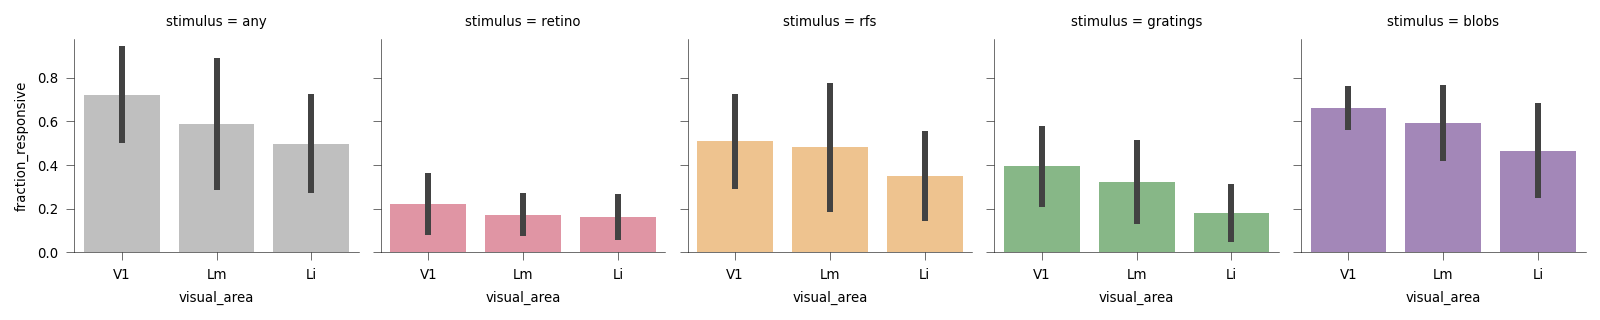

In [32]:
e_colors = {'retino': 'crimson', 'rfs': 'darkorange', 
            'gratings': 'green', 'blobs': 'indigo',
            'any': 'gray'}

g = sns.FacetGrid(col='stimulus', data=COUNTS, height=2,
                  col_order=['any', 'retino', 'rfs', 'gratings', 'blobs'],
                  hue='stimulus', palette=e_colors) #'colorblind')
g.map(sns.barplot, 'visual_area', 'fraction_responsive', 
         order=visual_areas, ci='sd', alpha=0.5)

# Select example cells spanning ALL stimuli

In [33]:
fit_thr=0.5; n_bootstrap_iters=1000; n_resamples=20;
assigned_cells, _ = select_assigned_cells(cells0, sdata, 
                                                      experiments=['gratings'])
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                                responsive_test=gratings_test, 
                                n_stds=n_stds, responsive_thr=gratings_thr, 
                                n_bootstrap_iters=n_bootstrap_iters, 
                                n_resamples=n_resamples)
gdata, missing_ = gutils.aggregate_ori_fits(assigned_cells, 
                                traceid=traceid, fit_desc=ori_fit_desc, 
                                return_missing=True) 
print(missing_)

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/gratings_utils.py:174: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb)


['Lm_20191111_JC120_fov1']


In [308]:
gof_thr=0.25
gratings_ = gdata[gdata['gof']>=gof_thr][['visual_area', 'datakey', 'cell']]\
            .drop_duplicates()
gratings_.groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,224,224
Lm,547,547
V1,621,621


In [309]:
rf_cells, rf_meta = select_assigned_cells(cells0, sdata, 
                                          experiments=['rfs', 'rfs10']) 
# Drop repeat FOVs by selecting those with most RF fits
do_spherical_correction=False
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                               do_spherical_correction=do_spherical_correction)
rfdata = rfutils.aggregate_rfdata(rf_meta, rf_cells, 
                            fit_desc=rf_fit_desc, reliable_only=False)
# Combined rfs5/rfs10
RFS = rfutils.average_rfs_select(rfdata)

# Get RF cells
rfs_ = rfdata_avg[['visual_area', 'datakey', 'cell']]\
            .drop_duplicates()
rfs_.groupby(['visual_area']).count()

N dpaths: 65, N unfit: 0
N datasets included: 65, N sessions excluded: 4


,datakey,cell
visual_area,,
Li,450,450
Lm,422,422
V1,654,654


In [310]:
# Get blobs
trial_epoch='plushalf'
responsive_test='ROC'
responsive_thr=0.05
BLOBS = aggr.get_aggregate_data('blobs', traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr, n_stds=n_stds)
objects_ = BLOBS[['visual_area', 'datakey', 'cell']].drop_duplicates()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['blobs']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [0.0 -15.0], y: [0.0 -5.0]


In [311]:
# retinodata
retino_thr=0.01
retino_delay=1
retinodata = load_aggregate_retinodata(traceid=traceid, 
                        mag_thr=retino_thr, delay_thr=retino_delay)
retino_ = get_responsive_retino(retinodata, mag_thr=retino_thr)


In [312]:
f_=[]
for (va, dk), curr_rfs in rfs_.groupby(['visual_area', 'datakey']):
    cells_1 = curr_rfs['cell'].unique()
    # Get gratings cells
    curr_grat = gratings_[(gratings_.visual_area==va) & (gratings_.datakey==dk)].copy()
    cells_2 = curr_grat['cell'].unique()
    # Get cells in both
    common_ = np.intersect1d(cells_1, cells_2)
    # Get blobs
    curr_obj = objects_[(objects_.visual_area==va) & (objects_.datakey==dk)].copy()
    cells_3 = curr_obj['cell'].unique()
    common_1 = np.intersect1d(common_, cells_3)
    # Get retino
    curr_ret = retino_[(retino_.visual_area==va) & (retino_.datakey==dk)].copy()
    cells_4 = curr_ret['cell'].unique()
    common_2 = np.intersect1d(common_1, cells_4)
    
    final_cells = curr_rfs[curr_rfs['cell'].isin(common_2)]
    f_.append(final_cells)
ccounts = pd.concat(f_)
ccounts.shape

(180, 3)

In [313]:
ccounts.groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,15,15
Lm,44,44
V1,121,121


In [314]:
ccounts[ccounts['visual_area']=='Li']

,visual_area,datakey,cell
61,Li,20190602_JC091_fov1,33.0
66,Li,20190602_JC091_fov1,39.0
67,Li,20190602_JC091_fov1,41.0
68,Li,20190602_JC091_fov1,42.0
69,Li,20190602_JC091_fov1,43.0
72,Li,20190602_JC091_fov1,47.0
74,Li,20190602_JC091_fov1,50.0
81,Li,20190602_JC091_fov1,64.0
85,Li,20190602_JC091_fov1,70.0
88,Li,20190602_JC091_fov1,73.0


In [315]:
va='Li'
#dk='20190602_JC091_fov1'

currd=[]
for dk, g in ccounts[(ccounts['visual_area']=='Li')].groupby(['datakey']):
    curr_rois = g['cell'].unique()
    nd = NDATA[(NDATA.visual_area=='Li') & (NDATA.datakey==dk)
                & (NDATA['cell'].isin(curr_rois))].copy()
    currd.append(nd)
bdata = pd.concat(currd, axis=0)
bdata.shape

(22488, 6)

In [316]:
# np.reshape(bdata.groupby(['config'])['response'].mean().index.tolist(), (10, 5)).T

In [317]:
li_ccounts = ccounts[(ccounts['visual_area']=='Li')].copy()

<IPython.core.display.Javascript object>


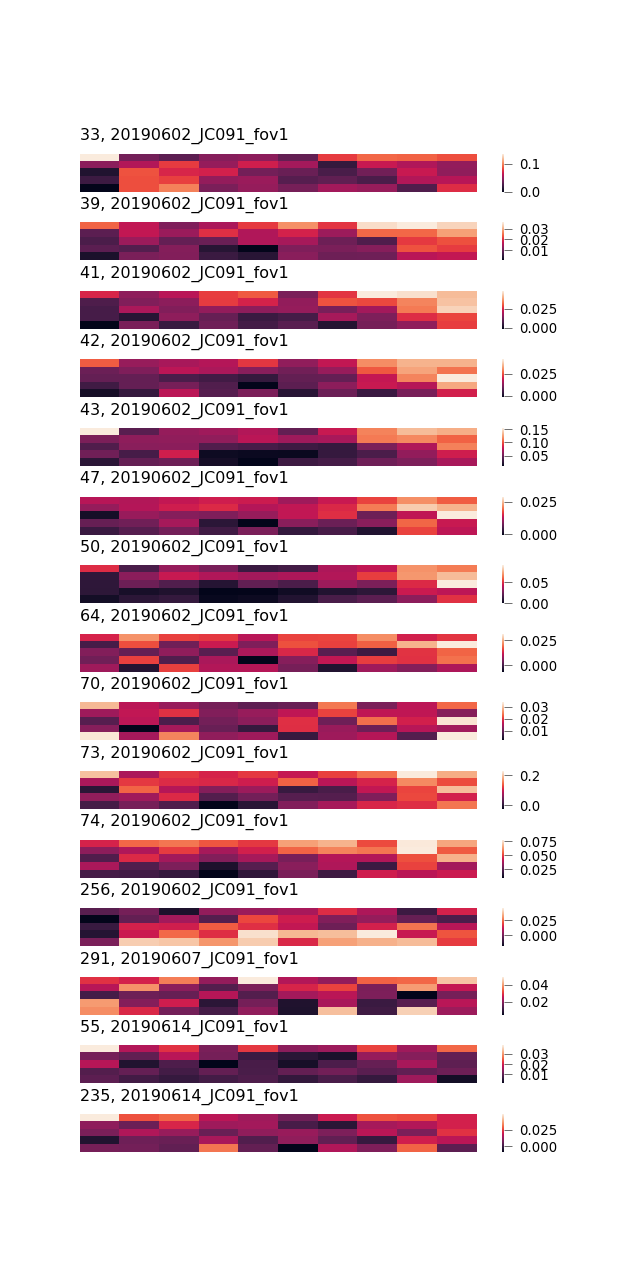

In [318]:
ncells_pass = li_ccounts.shape[0]
fig, axn = pl.subplots(ncells_pass, 1, figsize=(4,8))
for ai, ((dk, ri), df_) in enumerate(bdata.groupby(['datakey', 'cell'])):
    obj_map = np.reshape(df_.groupby(['config'])['response'].mean().values, (10, 5)).T
    ax=axn[ai]
    sns.heatmap(obj_map, ax=ax)
    ax.set_title('%i, %s' % (ri, dk), loc='left')
    ax.axis('off')
pl.subplots_adjust(wspace=0.5, hspace=0.8, bottom=0.1)

In [204]:
sdf = hutils.get_stimuli(dk, 'blobs')


In [337]:
assigned_cells[(assigned_cells.datakey=='20190607_JC091_fov1')]['cell'].unique()

array([512., 513., 514., 522.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,
        18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,
        44.,  50.,  51., 523., 524.,  92.,  93.,  94.,  95.,  96.,  97.,
        98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
       109., 110., 111., 112., 113., 114., 115., 116., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 153., 154., 155., 156., 157., 158., 159.,
       160., 161., 162., 163., 164., 165., 166., 167., 168., 169., 170.,
       171., 172., 173., 174., 175., 176., 177., 178., 179., 180., 181.,
       182., 183., 184., 185., 186., 187., 188., 189., 190., 191., 192.,
       193., 194., 195., 196., 197., 198., 199., 200., 201., 202., 203.,
       204., 205., 206., 207., 208., 209., 210., 211., 212., 213., 214.,
       215., 216., 217., 218., 219., 220., 221., 22

In [361]:
va='Li'
# dk = '20190614_JC091_fov1' #'20190602_JC091_fov1'
# rid = 304 #234 #43 #234
# dk = '20190602_JC091_fov1' #'20190602_JC091_fov1'
# rid = 51 #43 #43 #234
dk = '20190614_JC091_fov1' #'20190602_JC091_fov1'
rid = 343 #234 #43 #234

gd = gdata[(gdata.visual_area==va) & (gdata.datakey==dk) & (gdata['cell']==rid)].copy()
print('gratings, %.2f' % gd['gof'].max())

bd = BLOBS[(BLOBS.visual_area==va) & (BLOBS.datakey==dk) & (BLOBS['cell']==rid)].copy()
print('blobs, %.2f' % bd.dropna().groupby(['config']).mean()['response'].max())

rd = RFS[(RFS.visual_area==va) & (RFS.datakey==dk) & (RFS['cell']==rid)].copy()
print('RF: r2=%.2f' % rd['r2'].max())

retd = retino_[(retino_.visual_area==va) & (retino_.datakey==dk) & (retino_['cell']==rid)]
print(retd[['mag_az', 'mag_el']].max(axis=1))

gratings, nan
blobs, 0.09
RF: r2=0.94
Series([], dtype: float64)


In [362]:
RFS[(RFS.visual_area==va) & (RFS.datakey==dk) & (RFS['cell']==rid)]

,datakey,animalid,session,cell,x0,y0,fwhm_x,fwhm_y,theta,r2,...,ratio_xy,theta_c,theta_Mm_deg,major_axis,minor_axis,anisotropy,theta_Mm_c,aniso_index,visual_area,experiment
339,20190614_JC091_fov1,JC091,20190614,343.0,44.939706,-18.556217,26.652976,35.422658,1.320921,0.938588,...,0.752427,1.320921,165.683206,15.073471,11.341692,0.141274,-0.249875,-0.071405,Li,rfs10


In [363]:
rd.columns

Index(['datakey', 'animalid', 'session', 'cell', 'x0', 'y0', 'fwhm_x',
       'fwhm_y', 'theta', 'r2', 'fovnum', 'std_x', 'std_y', 'fwhm_avg',
       'std_avg', 'area', 'fx', 'fy', 'ratio_xy', 'theta_c', 'theta_Mm_deg',
       'major_axis', 'minor_axis', 'anisotropy', 'theta_Mm_c', 'aniso_index',
       'visual_area', 'experiment'],
      dtype='object')

In [364]:
session, animalid, fovn = hutils.split_datakey_str(dk)
fov='FOV%i_zoom2p0x' % fovn
try:
    roiid = roiutils.get_roiid_from_traceid(animalid, session, fov, 
                                            traceid=traceid)
except Exception as e:
    print(e)
    print("[%s] Unable to get roiid (%s)" % (dk, traceid))
    roiid=None
# Select best retino run (if there are multiple)
all_retinos = pd.DataFrame(retutils.get_average_mag_across_pixels(
                                            animalid, session, fov))
retinorun = all_retinos.loc[all_retinos[1].idxmax()][0]
retinoid, RETID = retutils.load_retino_analysis_info(animalid, session, fov,
                                    roiid=roiid)
print(retinorun, retinoid)

retino_run1 analysis002


In [365]:
soma_traces = retutils.load_roi_traces(animalid, session, fov, run=retinorun,
                 analysisid=retinoid, trace_type='corrected', detrend_after_average=True)


In [366]:
dff_soma = dict((cond, (tdf - tdf.mean(axis=0))/ tdf.mean(axis=0)) for cond, tdf in soma_traces.items())


<IPython.core.display.Javascript object>


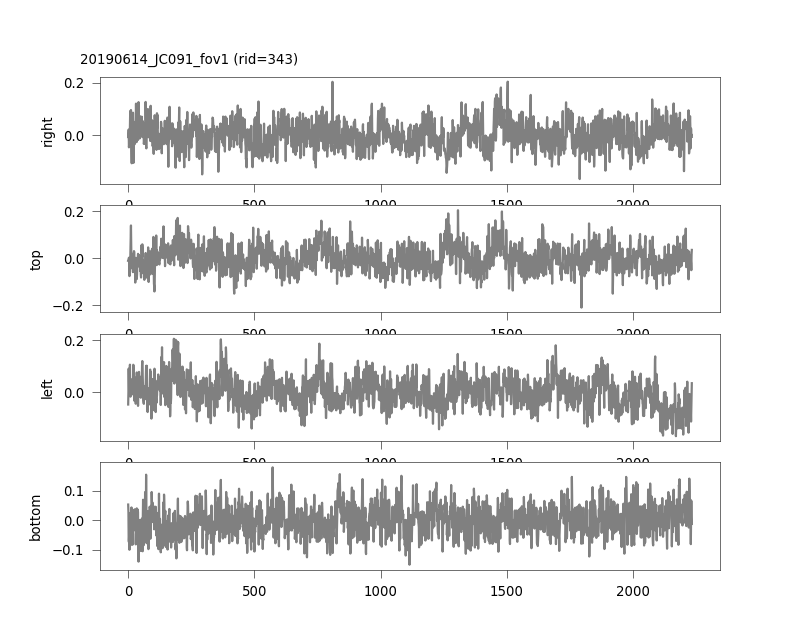

Text(0.1, 0.9, '20190614_JC091_fov1 (rid=343)')

In [372]:
retino_conds = dff_soma.keys()
fig, axn = pl.subplots(len(retino_conds), 1)
for ax, cond in zip(axn.flat, retino_conds):
    ax.plot(dff_soma[cond][rid].values, lw=1, color='gray')
    ax.set_ylabel(cond)
    
fig.text(0.1, 0.9, '%s (rid=%i)' % (dk, rid))